In [6]:
import itertools
import os
import json
import copy
import sys
from collections import defaultdict
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
import seaborn as sns
import scipy.stats as stats
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
from scipy import stats
import seaborn as sns
from scipy import stats
import sys
import seaborn as sns
%cd -q top-k-mallows
import permutil as pu
%cd -q ../..
from utils import *

# Each version of the dataset in the form of :

$$M = \begin{bmatrix} &  & M_{1} & M_{2} & \cdots & M_{|M|} & H_{1} & H_{2} & \cdots &H_{|H|} \\
S_1 & u^{S_1}_1  &  &   &   &   &   &   &   &  \\
S_1 & \cdots  &  &   &   &   &   &   &   &  \\
S_1 & u^{S_1}_{|U|}   &  &   &   &   &   &   &   &  \\
 \cdots &     &  &   &   &   &   &   &   &  \\
  \cdots &    &  &   &   &   &   &   &   &  \\
S_{|S|} & u^{S_{|S|}}_1  &  &   &   &   &   &   &   &  \\
S_{|S|} & \cdots  &  &   &   &   &   &   &   &  \\
S_{|S|} & u^{S_{|S|}}_{|U|}   &  &   &   &   &   &   &   &  \\
\end{bmatrix}$$


# Explore Dataset and Check Correlation with Literature

#### Check TAC from https://arxiv.org/pdf/1909.02622.pdf


In [7]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv',
 'DIALOG_tc.csv',
 'FLICKR.csv',
 'MLQE.csv',
 'REAL_SUM.csv',
 'SUM_EVAL.csv',
 'TAC_08.csv',
 'TAC_09.csv',
 'TAC_11.csv'
]
data_path = 'final_df'
ds_to_load = 'DIALOG_pc.csv'

In [8]:
count = 0
for ds in AVAILBLE_DATASETS:
    print('--------------------------------------')
    print( 'Loading DS',ds)
    considered_df = pd.read_csv(os.path.join(data_path,ds)).set_index(['System','Utterance'])
    print(considered_df.shape)
    count += considered_df.shape[0]*considered_df.shape[1]
    is_metric = ['H:' in i for i in considered_df.columns]
    human_metrics = []
    for index,i in enumerate(considered_df.columns):
        if is_metric[index]: 
            print('Human',i)
            human_metrics.append(i)
        else:
            pass
            print('Metric',i)
print('Number of points',count)

--------------------------------------
Loading DS DIALOG_pc.csv
(240, 19)
Human H:engaging
Human H:context
Human H:natural
Human H:overall
Human H:understandable
Human H:useknowledge
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrfpp
Metric BERTScore
Metric MoverScore
--------------------------------------
Loading DS DIALOG_tc.csv
(300, 19)
Human H:engaging
Human H:context
Human H:natural
Human H:overall
Human H:understandable
Human H:useknowledge
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrfpp
Metric BERTScore
Metric MoverScore
--------------------------------------
Loading DS FLICKR.csv
(864, 14)
Human H:overall
Metric S3_pyr
Metric S3_resp
Metric ROUGE_WE_1
Metric ROUGE_WE_2
Metric JS_1
Metric JS_2
Metric ROUGE_L
Metric ROUGE_1
Metric ROUGE_2
Metric BLEU
Metric Chrf

# Analysis of the methods

### Real world perturbation experiments : on metrics

In [9]:
def generate_metric_experiments(number_of_samples,path,ds,seed=42):
    considered_df = pd.read_csv(os.path.join(path,ds)).set_index(['System','Utterance'])
    considered_columns = list(considered_df.columns)
    random.seed(seed)
    final_dic = {
        'mean':{},
        'direct':{},
        '2steps':{}
    }
    for i in range(1,len(considered_columns)+1):
        final_dic['mean']['{}'.format(i)] = []
        final_dic['direct']['{}'.format(i)] = []
        final_dic['2steps']['{}'.format(i)] = []

    for _ in tqdm(range(number_of_samples),'Nbs of Experiments'):
        random.shuffle(considered_columns)
        for i in tqdm(range(1,len(considered_columns)+1),'Running For DF'):
            running_df =  considered_df[considered_columns[:i]]
            c_mean_aggreg = mean_aggregation_instance_level(running_df)[0]
            c_direct_aggreg = direct_aggregation(running_df)
            c_two_level_aggreg = two_levels_aggregation(running_df)
            final_dic['mean']['{}'.format(i)].append(c_mean_aggreg)
            final_dic['direct']['{}'.format(i)].append(c_direct_aggreg)
            final_dic['2steps']['{}'.format(i)].append(c_two_level_aggreg)
            
    return final_dic

def compute_distances(final_dic,path,ds):
    considered_df = pd.read_csv(os.path.join(path,ds)).set_index(['System','Utterance'])
    scores_to_plot = {
    'criterion': [],
    'method': [],
    'correlation': [],
        'kendallTau': [],
    }
    ref_ranks = {
         'mean':mean_aggregation_instance_level(considered_df)[0],
        'direct': direct_aggregation(considered_df),
        '2steps': two_levels_aggregation(considered_df)
    }
    for k,v in final_dic.items(): 
        ref_rank = ref_ranks[k]
        for sub_k,sub_v in tqdm(v.items(),'Itterations'):
            for score in sub_v:
                scores_to_plot['criterion'].append(int(sub_k)/considered_df.shape[1])
                scores_to_plot['method'].append(k)
                scores_to_plot['correlation'].append(stats.kendalltau(score, ref_rank)[0])
                scores_to_plot['kendallTau'].append(stats.kendalltau(score, ref_rank))
    return scores_to_plot


def plot_and_save(df,considered_ds,title):
    sns.set_palette("Set2")
    fig,ax = plt.subplots(figsize=(6,6))
    sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)
    plt.yticks(fontsize=20) #hue="losses",
    plt.xticks(fontsize=20) #hue="losses",
    #plt.title('{}'.format(title),fontsize=30)
    plt.ylabel('$\\tau$',fontsize=30)
    plt.xlabel('% criterion',fontsize=25)
    plt.tight_layout()
    L=plt.legend(fontsize=23)
    for line in L.get_lines():
        line.set_linewidth(5.0)
    #L.get_texts()[0].set_text('Aggreg.')
    L.get_texts()[0].set_text('$\\sigma^{mean}$')
    L.get_texts()[1].set_text('$\\sigma^{l}$')
    L.get_texts()[2].set_text('$\\sigma^{2l}$')

    #N = 6
    #ax.set_yticks(np.round(np.linspace(0.76, 1, N), 2))

    N = 5
    ax.set_xticks(np.round(np.linspace(0, 1, N), 2))
    plt.savefig('two_level_ranking_{}.pdf'.format(considered_ds),format='pdf')
    plt.show()


In [10]:
print('Available ds',AVAILBLE_DATASETS)
ds2title = {
    
    'DIALOG_pc.csv':'PersonaChat',
    'DIALOG_tc.csv':'TopicChat',
    'FLICKR.csv':'FLICKR',
    'MLQE.csv':'MLQE',
    'REAL_SUM.csv':'RealSum',
    'SUM_EVAL.csv':'SumEval',
    'TAC_08.csv':'TAC08',
    'TAC_09.csv':'TAC09',
    'TAC_11.csv':'TAC11'
    
}
GENERATE_DATA_ROBUTNESS_SYSTEM  = False

Available ds ['DIALOG_pc.csv', 'DIALOG_tc.csv', 'FLICKR.csv', 'MLQE.csv', 'REAL_SUM.csv', 'SUM_EVAL.csv', 'TAC_08.csv', 'TAC_09.csv', 'TAC_11.csv']


#### Generating Examples

In [11]:
path = 'final_df'
number_of_samples=50
if GENERATE_DATA_ROBUTNESS_SYSTEM:
    for ds in AVAILBLE_DATASETS:
        title = ds2title[ds]
        synthetic_metric_scores =  generate_metric_experiments(number_of_samples,path,ds)
        file = 'synthetic_metric_scores_{}_{}.json'.format(ds,number_of_samples)
        with open('synthetic_metrics_scores/{}'.format(file),'w', encoding='utf-8') as file:
            for k,v in synthetic_metric_scores.items():
                for sub_k,sub_v in v.items():
                    try:
                        synthetic_metric_scores[k][sub_k] = [i.tolist() for i in sub_v]
                    except: 
                        print('Error')
            json.dump(synthetic_metric_scores,file)
        scores_to_plot = compute_distances(synthetic_metric_scores,path,ds)
        df_to_plot = pd.DataFrame(scores_to_plot) 
        plot_and_save(df_to_plot,ds,title)

#### Loading data

Itterations:   0%|          | 0/19 [00:00<?, ?it/s]

Itterations:   0%|          | 0/19 [00:00<?, ?it/s]

Itterations:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


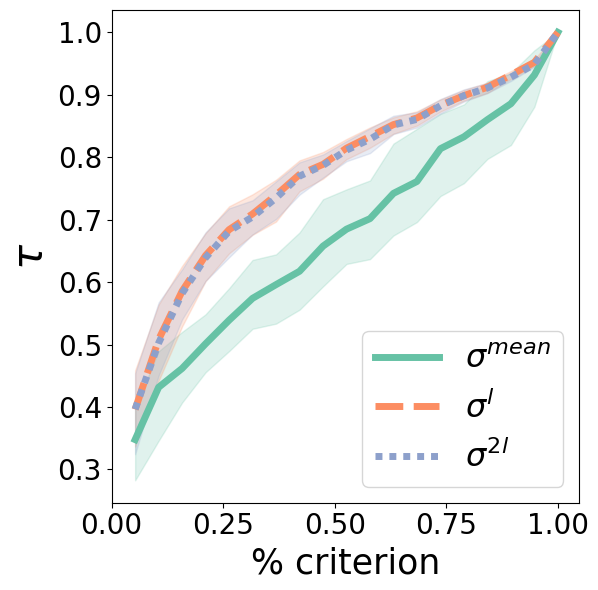

Itterations:   0%|          | 0/19 [00:00<?, ?it/s]

Itterations:   0%|          | 0/19 [00:00<?, ?it/s]

Itterations:   0%|          | 0/19 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


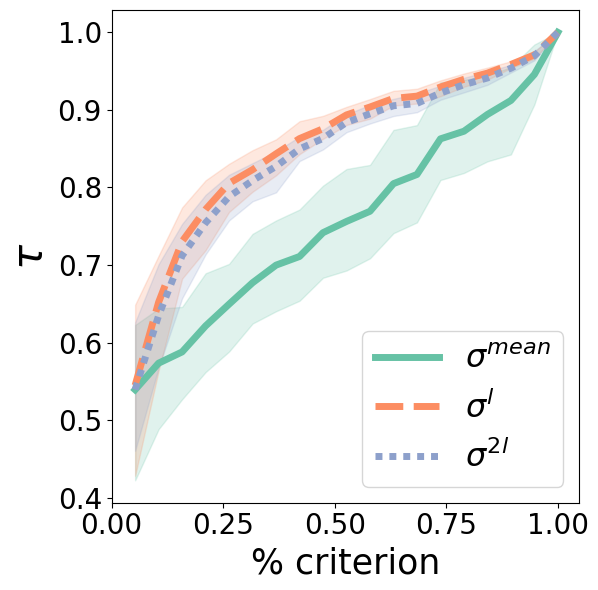

Itterations:   0%|          | 0/14 [00:00<?, ?it/s]

Itterations:   0%|          | 0/14 [00:00<?, ?it/s]

Itterations:   0%|          | 0/14 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


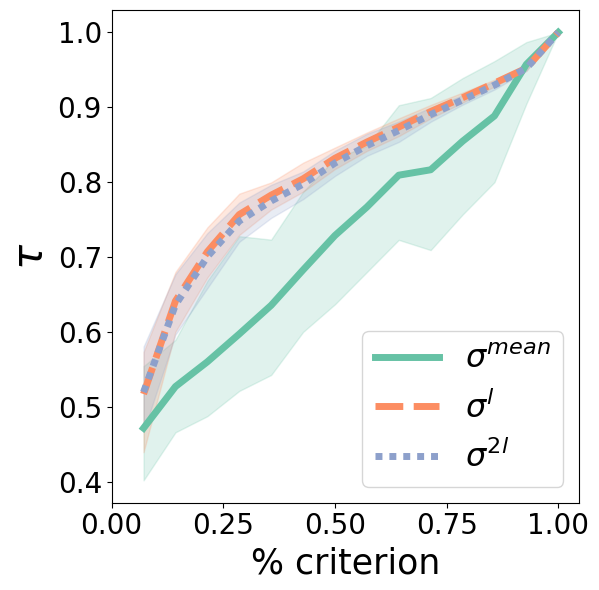

Itterations:   0%|          | 0/10 [00:00<?, ?it/s]

Itterations:   0%|          | 0/10 [00:00<?, ?it/s]

Itterations:   0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


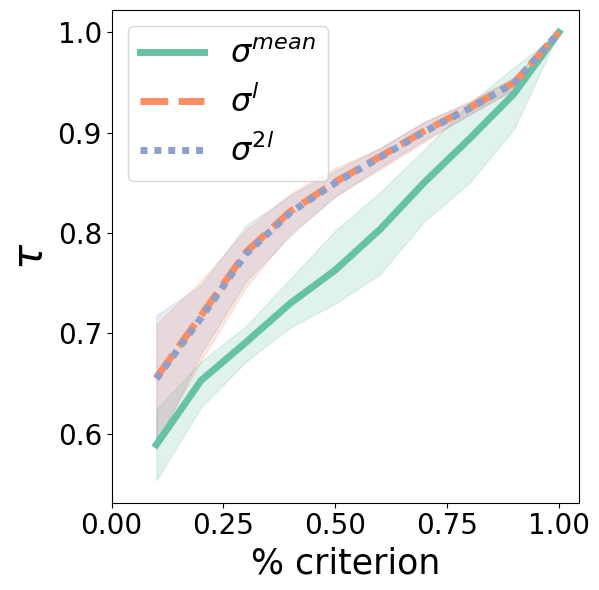

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


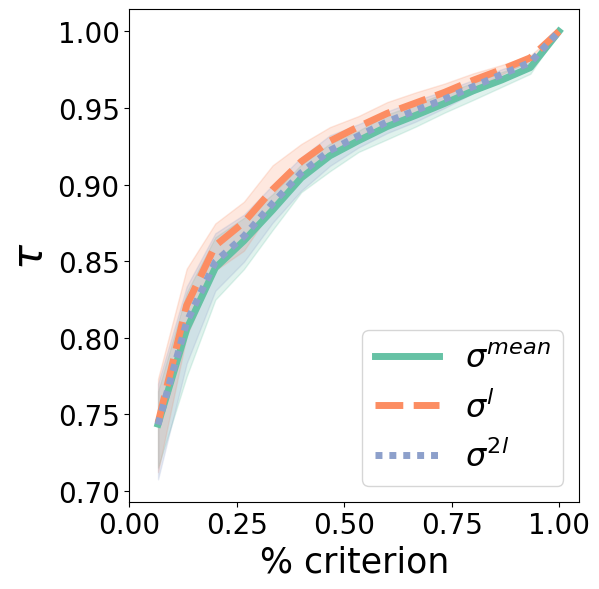

Itterations:   0%|          | 0/17 [00:00<?, ?it/s]

Itterations:   0%|          | 0/17 [00:00<?, ?it/s]

Itterations:   0%|          | 0/17 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


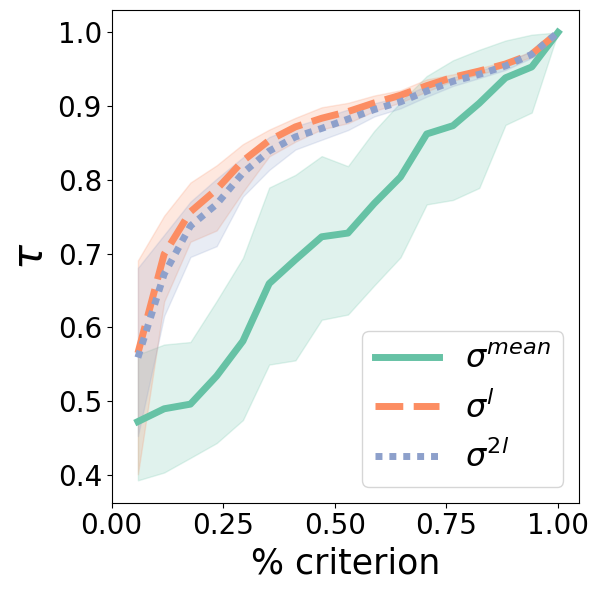

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


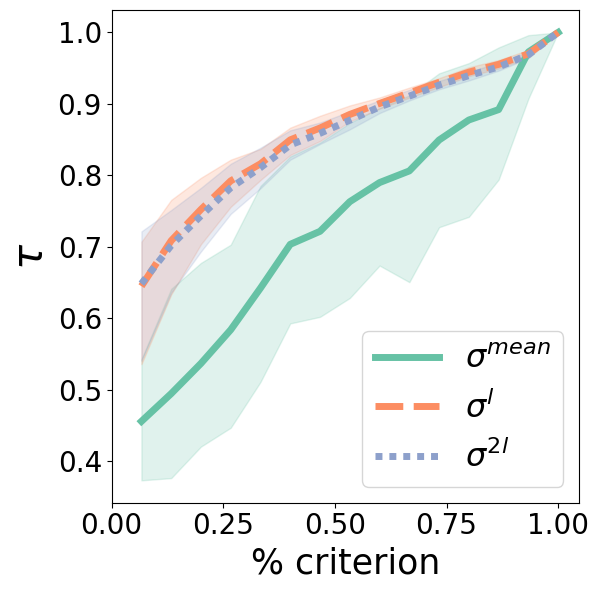

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


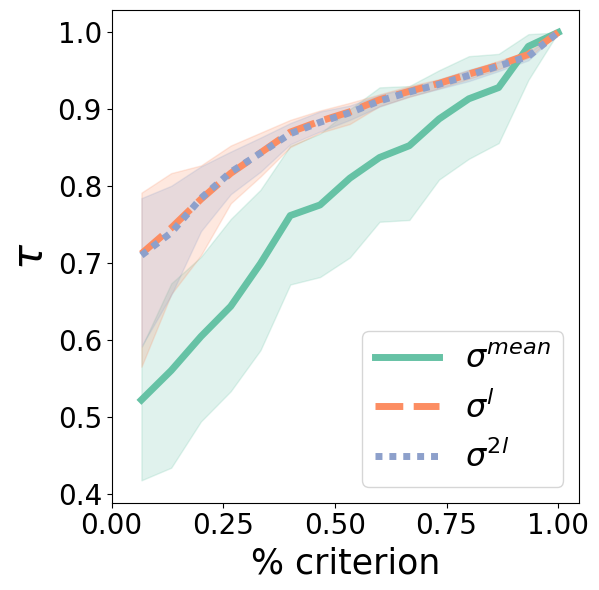

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

Itterations:   0%|          | 0/15 [00:00<?, ?it/s]

/tmp/ipykernel_83824/3608044124.py:55: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="criterion", y="correlation", hue="method",style="method",data=df_to_plot,linewidth = 5,ci=100)


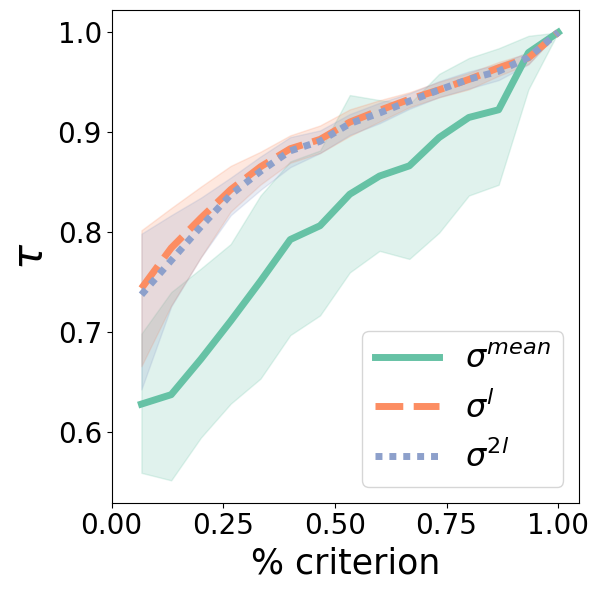

In [12]:
for considered_ds in AVAILBLE_DATASETS:
    number_of_samples=50
    path = 'final_df'
    file = 'synthetic_metric_scores_{}_{}.json'.format(considered_ds,number_of_samples)

    with open('synthetic_metrics_scores/{}'.format(file),'r', encoding='utf-8') as file:
        file_results = json.load(file)
    scores_to_plot = compute_distances(file_results,path,considered_ds)
    df_to_plot = pd.DataFrame(scores_to_plot)   
    plot_and_save(df_to_plot,considered_ds,'')

### Real world perturbation experiments : on systems

In [13]:
GENERATE_DATA_ROBUTNESS_SYSTEM= False

In [14]:
def generate_system_experiment(number_of_samples,path= 'final_df',ds='TAC_08.csv',seed=42):
    random.seed(seed)
    l_final_dic = []
    data_df = pd.read_csv(os.path.join(path,ds)).set_index(['System','Utterance'])
    number_of_systems = len(copy.deepcopy(list(set(data_df.reset_index().System.values)))) +1
    for number_of_systems in tqdm(range(1,number_of_systems + 1),'Number of Systems'): # start at 2
        for _ in tqdm(range(number_of_samples),'Experiments'):
            data_df = pd.read_csv(os.path.join(path,ds)).set_index(['System','Utterance'])
            systems = copy.deepcopy(list(set(data_df.reset_index().System.values)))
            random.shuffle(systems)
            df = data_df[data_df.index.isin(systems, level=0)]
            df = df.reindex(systems, axis=0, level=0)
            ref_ranks = {
             'mean':mean_aggregation_instance_level(df)[0][:number_of_systems],
            'direct': direct_aggregation(df)[:number_of_systems],
            '2steps': two_levels_aggregation(df)[:number_of_systems]
                    }
            selected_systems = systems[:number_of_systems]
            running_df = df[df.index.isin(selected_systems, level=0)]
            running_df_new = running_df.reindex(selected_systems, axis=0, level=0)


            runing_ranks = {
             'mean':mean_aggregation_instance_level(running_df)[0],
            'direct': direct_aggregation(running_df),
            '2steps': two_levels_aggregation(running_df)
                    }

            final_dic = {}

            for r_key in ref_ranks.keys():
                    final_dic['{}'.format(r_key)] = stats.kendalltau(ref_ranks[r_key], runing_ranks[r_key])[0]
            l_final_dic.append(final_dic)  
    return l_final_dic

#### Generating Examples

In [15]:
number_of_samples= 50
if GENERATE_DATA_ROBUTNESS_SYSTEM:
    for ds in tqdm(AVAILBLE_DATASETS,'datasets'):
        l_final_dic=  generate_system_experiment(number_of_samples,path= 'final_df',ds=ds,seed=42)
        df_dic = {
            'type':[],
            'correlation':[],
            'nbs':[]
        }
        for index,c_dic in enumerate(l_final_dic):
            index_runing=index // number_of_samples 
            for k,v in c_dic.items():
                df_dic['nbs'].append(index_runing)
                df_dic['type'].append(k)
                df_dic['correlation'].append(v)
        with open('final_dic_ajout_de_systems_{}.json'.format(ds),'w') as file:
            json.dump(l_final_dic,file)
        plt.figure(figsize=(12,8))
        df_to_plot = pd.DataFrame(df_dic)
        sns.lineplot(x="nbs", y="correlation", hue="type",data=df_to_plot)
        plt.show()


#### Loading Examples

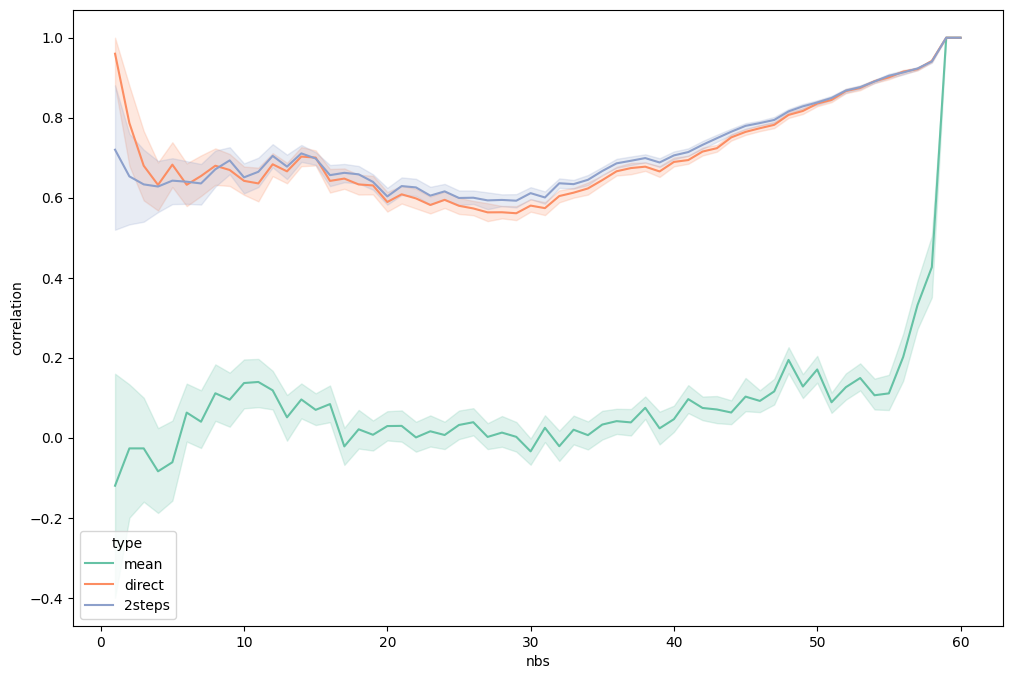

In [16]:
ds = 'DIALOG_pc.csv'
with open('final_dic_ajout_de_systems_{}.json'.format(ds),'r') as file:
        file_dic = json.load(file)
plt.figure(figsize=(12,8))
df_dic = {
    'type':[],
    'correlation':[],
    'nbs':[]
}
for index,c_dic in enumerate(file_dic):
    index_runing=index // number_of_samples 
    for k,v in c_dic.items():
        df_dic['nbs'].append(index_runing)
        df_dic['type'].append(k)
        df_dic['correlation'].append(v)
df_to_plot = pd.DataFrame(df_dic)
sns.lineplot(x="nbs", y="correlation", hue="type",data=df_to_plot)
plt.show()

### Real world perturbation experiments : on systems test size

In [17]:
def generate_testsize_experiment(number_of_samples,path= 'final_df',ds='TAC_08.csv',seed=42):
    random.seed(seed)
    l_final_dic = []
    data_df = pd.read_csv(os.path.join(path,ds)).set_index(['System','Utterance'])
    nb_of_systems = len(list(set(data_df.reset_index().System.values)))
    assert data_df.shape[0] % nb_of_systems == 0
    number_of_instance = data_df.shape[0] // nb_of_systems 
    final_ranks = {
             'mean':mean_aggregation_instance_level(data_df)[0],
            'direct': direct_aggregation(data_df),
            '2steps': two_levels_aggregation(data_df)
                    }


    utterances = list(set(data_df.reset_index().Utterance.values))
    for i in tqdm(range(1,number_of_instance+1),'Number of Instances'): # start at 1
        for _ in tqdm(range(number_of_samples),'Experiments'):
            random.shuffle(utterances)
            newindex = sorted(data_df.index, key=lambda x: utterances.index(x[1]))
            newindex = sorted(newindex, key=lambda tup: tup[0]) 
            df = data_df.reindex(newindex,axis = 0)
            df = df.loc[df.index.get_level_values(1).isin(utterances[:i])]
            runing_ranks = {
             'mean':mean_aggregation_instance_level(df)[0],
            'direct': direct_aggregation(df),
            '2steps': two_levels_aggregation(df)
                    }
            final_dic = {}
            for r_key in runing_ranks.keys():
                    final_dic['{}'.format(r_key)] = stats.kendalltau(final_ranks[r_key], runing_ranks[r_key])[0]
            l_final_dic.append(final_dic)  
    return l_final_dic
def plot_and_save_test(df,considered_ds,title):
    sns.set_palette("Set2")
    fig,ax = plt.subplots(figsize=(6,6))
    sns.lineplot(x="nbs", y="correlation", hue="type",style="type",data=df_to_plot,linewidth = 5,ci=100)
    plt.yticks(fontsize=20) #hue="losses",
    plt.xticks(fontsize=20) #hue="losses",
    #plt.title('{}'.format(title),fontsize=30)
    plt.ylabel('$\\tau$',fontsize=30)
    plt.xlabel('% size',fontsize=25)
    plt.tight_layout()
    L=plt.legend(fontsize=23)
    for line in L.get_lines():
        line.set_linewidth(5.0)
    #L.get_texts()[0].set_text('Aggreg.')
    L.get_texts()[0].set_text('$\\sigma^{mean}$')
    L.get_texts()[1].set_text('$\\sigma^{l}$')
    L.get_texts()[2].set_text('$\\sigma^{2l}$')

    #N = 6
    #ax.set_yticks(np.round(np.linspace(0.76, 1, N), 2))

    N = 5
    ax.set_xticks(np.round(np.linspace(0, 1, N), 2))
    plt.savefig('test_two_level_ranking_{}.pdf'.format(considered_ds),format='pdf')
    plt.show()

#### Generating Examples

In [18]:
GENERATE_DATA_ROBUTNESS_TEST = False
if GENERATE_DATA_ROBUTNESS_TEST:
    number_of_samples = 50
    #long = [i for i in AVAILBLE_DATASETS if i not in ['DIALOG_pc.csv','FLICKR.csv','SUM_EVAL.csv','TAC_08.csv']] # 5 are enough
    long = ['TAC_11.csv']
    for ds in tqdm(long):
        print(ds)
        l_final_dic=generate_testsize_experiment(number_of_samples,path= 'final_df',ds=ds,seed=42)
        df_dic = {
            'type':[],
            'correlation':[],
            'nbs':[]
        }
        for index,c_dic in enumerate(l_final_dic):
            index_runing=index // number_of_samples 
            for k,v in c_dic.items():
                df_dic['nbs'].append(index_runing / (len(l_final_dic) //number_of_samples ))
                df_dic['type'].append(k)
                df_dic['correlation'].append(v)
        with open('final_dic_testsize_{}_{}.json'.format(ds,number_of_samples),'w') as file:
            json.dump(df_dic,file)
        print('Considered ds',ds)
        df_to_plot = pd.DataFrame(df_dic)
        plot_and_save_test(df_to_plot,considered_ds,'')

#### Loading

TAC_11.csv


/tmp/ipykernel_83824/2625686837.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 100)` for the same effect.

  sns.lineplot(x="nbs", y="correlation", hue="type",style="type",data=df_to_plot,linewidth = 5,ci=100)


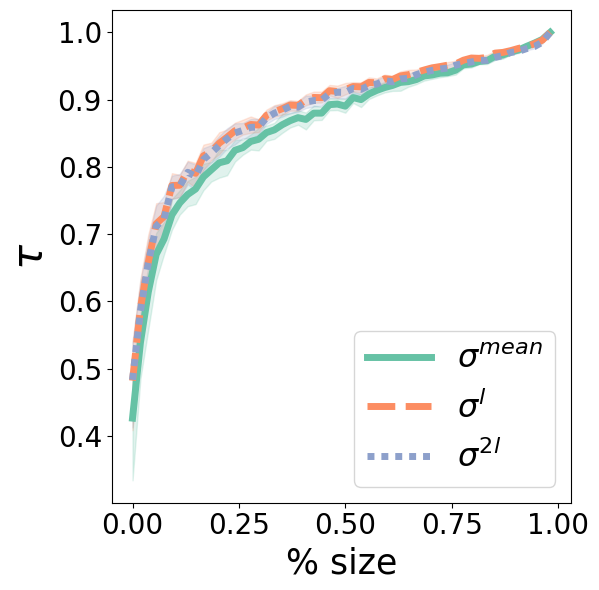

In [19]:
number_of_samples = 50
for ds in AVAILBLE_DATASETS[-1:]:
    if True:#ds not in long:
        print(ds)
        with open('final_dic_testsize_{}_{}.json'.format(ds,number_of_samples),'r') as file:
            l_final_dic= json.load(file)
        df_to_plot = pd.DataFrame(l_final_dic)
        plot_and_save_test(df_to_plot,ds,'')

# Figure 4 + Appendix

In [20]:
def analyse_agreements(data_path, type_of_agreement=1,aggrement = False):
    final_to_plot = {
       'ds':[],
        'is_1':[], #is equal
        'is_3':[],
        'is_5':[],
        'is_10':[],
        'tau':[],
        'method':[],
        'number':[],
        "agreement":[],
        'moyen_kendall':[],
        }
    max_number_of_systems= 20
    #for i in range(max_number_of_systems):
    #    final_to_plot['{}'.format(i)] = []
    method = {
        "1":"mean22l",
        "2":'direct22l',
        "0":'mean2direct'
    }
    for dataset in tqdm(AVAILBLE_DATASETS,'Datasets'):
        assert type_of_agreement in [1,-1]
        considered_df = pd.read_csv(os.path.join(data_path,dataset)).set_index(['System','Utterance'])
        # create rankings
        #mean_aggreg = reverse_ranking(mean_aggregation_instance_level(considered_df)[0])
        mean_aggreg = np.argsort(-np.array(mean_aggregation_instance_level(considered_df)[0]))[::-1]
        #direct_aggreg = reverse_ranking(direct_aggregation(considered_df))
        direct_aggreg = np.argsort(-np.array(direct_aggregation(considered_df)))[::-1]
        #two_level_aggreg = reverse_ranking(two_levels_aggregation(considered_df))
        two_level_aggreg = np.argsort(-np.array(two_levels_aggregation(considered_df)))[::-1]
        comparizons = [(mean_aggreg,direct_aggreg),(direct_aggreg,two_level_aggreg),(mean_aggreg,two_level_aggreg)]
        for index, (a,b) in enumerate(comparizons):
            
            
            if type_of_agreement == 1:
                for i in range(1,max_number_of_systems):

                    
                    element_a = [j for j in a[-i:] if j in b[-i:]]
                    element_b = [j for j in b[-i:] if j in a[-i:]]
                    assert len(element_a) == len(element_b)
                    
                    if len(element_a) > 1 or aggrement:
                        final_to_plot['moyen_kendall'].append(stats.kendalltau(element_a, element_b)[0])
                    
                        final_to_plot['method'].append(method[str(index)])
                        final_to_plot['ds'].append(dataset)
                        final_to_plot['number'].append(i)
                        final_to_plot['agreement'].append(pu.distance(a[-i:], b[-i:])/i)

                        #final_to_plot['3'].append(interection_length(a[-3:], b[-3:]))
                        #final_to_plot['5'].append(interection_length(a[-5:], b[-5:]))
                        #final_to_plot['10'].append(interection_length(a[-10:], b[-10:]))
                        final_to_plot['is_1'].append(a[-1 ] == b[-1:])
                        final_to_plot['is_3'].append(a[-3:] == b[-3:])
                        final_to_plot['is_5'].append(a[-5:] == b[-5:])
                        final_to_plot['is_10'].append(a[-10:] == b[-10:])
                        final_to_plot['tau'].append(stats.kendalltau(a, b)[0] )

            else :
                for i in range(max_number_of_systems):
                    final_to_plot['{}'.format(i)].append(pu.distance(a[:i], b[:i]))
                #final_to_plot['1'].append(interection_length(a[:1], b[:1]))
                #final_to_plot['3'].append(interection_length(a[:3], b[:3]))
                #final_to_plot['5'].append(interection_length(a[:5], b[:5]))
                #final_to_plot['10'].append(interection_length(a[:10], b[:10]))  
                final_to_plot['is_1'].append(a[0] == b[0])
                final_to_plot['is_3'].append(a[:3] == b[:3])
                final_to_plot['is_5'].append(a[:5] == b[:5])
                final_to_plot['is_10'].append(a[:10] == b[:10])
                final_to_plot['tau'].append(stats.kendalltau(a, b)[0] )
    return final_to_plot

In [24]:
data_df = pd.DataFrame(analyse_agreements('final_df/'))


Datasets:   0%|          | 0/9 [00:00<?, ?it/s]

#### Global Kendall

In [25]:
data_df[['tau','method',"ds"]].groupby(['ds',"method"]).mean()

tau
ds            method               
DIALOG_pc.csv direct22l   -0.080226
              mean22l      0.322034
              mean2direct -0.105085
DIALOG_tc.csv direct22l   -0.016949
              mean22l      0.276836
              mean2direct -0.150282
FLICKR.csv    direct22l    0.001731
              mean22l      0.245414
              mean2direct -0.043960
MLQE.csv      direct22l   -0.036609
              mean22l      0.018819
              mean2direct -0.000468
REAL_SUM.csv  direct22l    0.285253
              mean22l      0.325657
              mean2direct  0.237980
SUM_EVAL.csv  direct22l    0.044040
              mean22l      0.070303
              mean2direct  0.004040
TAC_08.csv    direct22l    0.140071
              mean22l      0.528369
              mean2direct  0.101064
TAC_09.csv    direct22l    0.067653
              mean22l      0.372093
              mean2direct  0.192389
TAC_11.csv    direct22l   -0.059197
              mean22l      0.378436
              mean2direct  0.071882

### Agreement Top/Last Systems

Datasets:   0%|          | 0/9 [00:00<?, ?it/s]

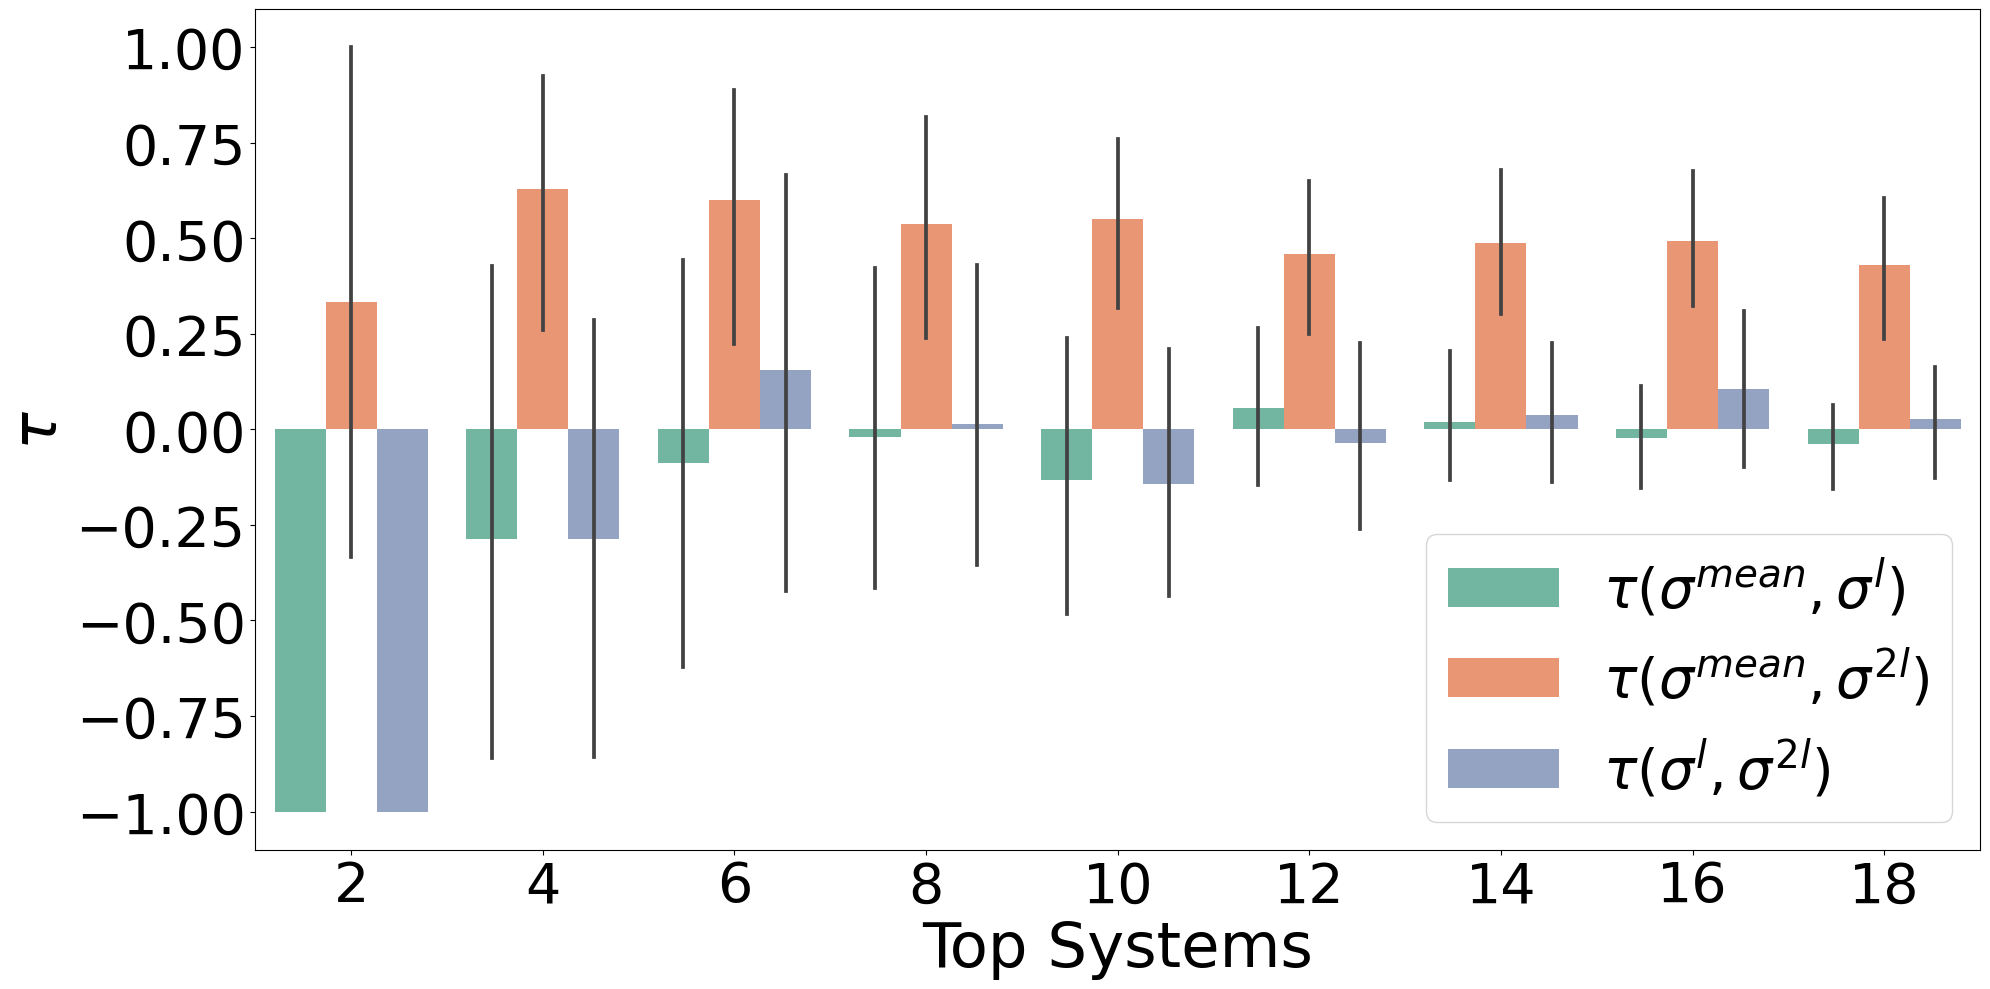

In [26]:
final_to_plot=  analyse_agreements(data_path = 'final_df', type_of_agreement=1,aggrement = False) 
data_df =pd.DataFrame(final_to_plot)
plt.figure(figsize=(20,10))
sns.set_palette("Set2")
data_filter = data_df[data_df.number.isin([int(i) for i in range(0,21,2)])]
sns.barplot(data=data_filter, x="number", y="moyen_kendall",hue='method')
plt.ylabel('$\\tau$',size = 45)
leg = plt.legend(fontsize=40)
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('$\\tau(\\sigma^{mean},\\sigma^{l})$')
leg.get_texts()[1].set_text('$\\tau(\\sigma^{mean},\\sigma^{2l})$')
leg.get_texts()[2].set_text('$\\tau(\\sigma^{l},\\sigma^{2l})$')
plt.yticks(fontsize=40) #hue="losses",
plt.xticks(fontsize=40) #hue="losses",
plt.xlabel('Top Systems',size = 45)
plt.tight_layout()
plt.savefig('bar_all_ranking_analysis.pdf',format='pdf')

Datasets:   0%|          | 0/9 [00:00<?, ?it/s]

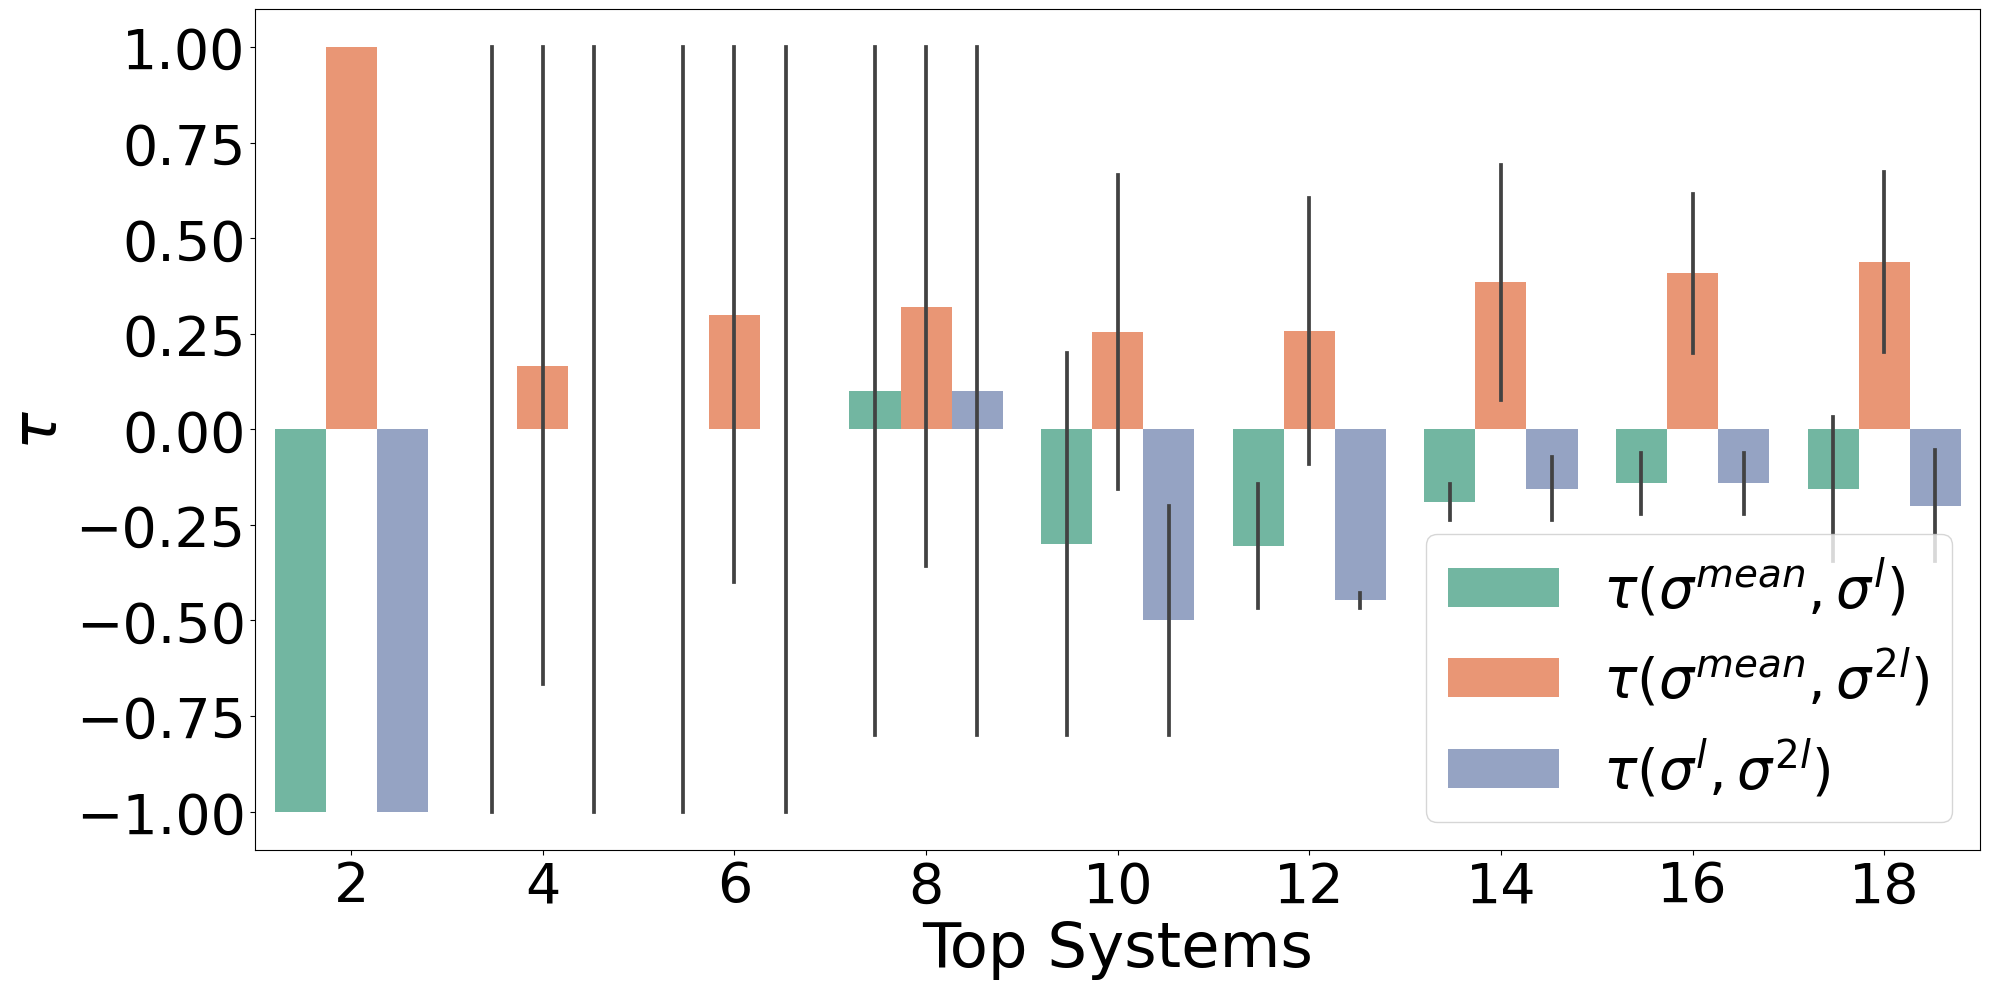

In [27]:
final_to_plot=  analyse_agreements(data_path = 'final_df', type_of_agreement=1,aggrement = False) 
data_df =pd.DataFrame(final_to_plot)
plt.figure(figsize=(20,10))
plt.tight_layout()
sns.set_palette("Set2")
data_filter = data_df[data_df.number.isin([int(i) for i in range(0,21,2)])]
data_filter = data_filter[data_filter.ds.isin(['DIALOG_pc.csv','DIALOG_tc.csv'])]
sns.barplot(data=data_filter, x="number", y="moyen_kendall",hue='method')
plt.ylabel('$\\tau$',size = 45)
leg = plt.legend(fontsize=40)
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('$\\tau(\\sigma^{mean},\\sigma^{l})$')
leg.get_texts()[1].set_text('$\\tau(\\sigma^{mean},\\sigma^{2l})$')
leg.get_texts()[2].set_text('$\\tau(\\sigma^{l},\\sigma^{2l})$')
plt.yticks(fontsize=40) #hue="losses",
plt.xticks(fontsize=40) #hue="losses",
plt.xlabel('Top Systems',size = 45)
plt.tight_layout()
plt.savefig('bar_dialog_ranking_analysis.pdf',format='pdf')

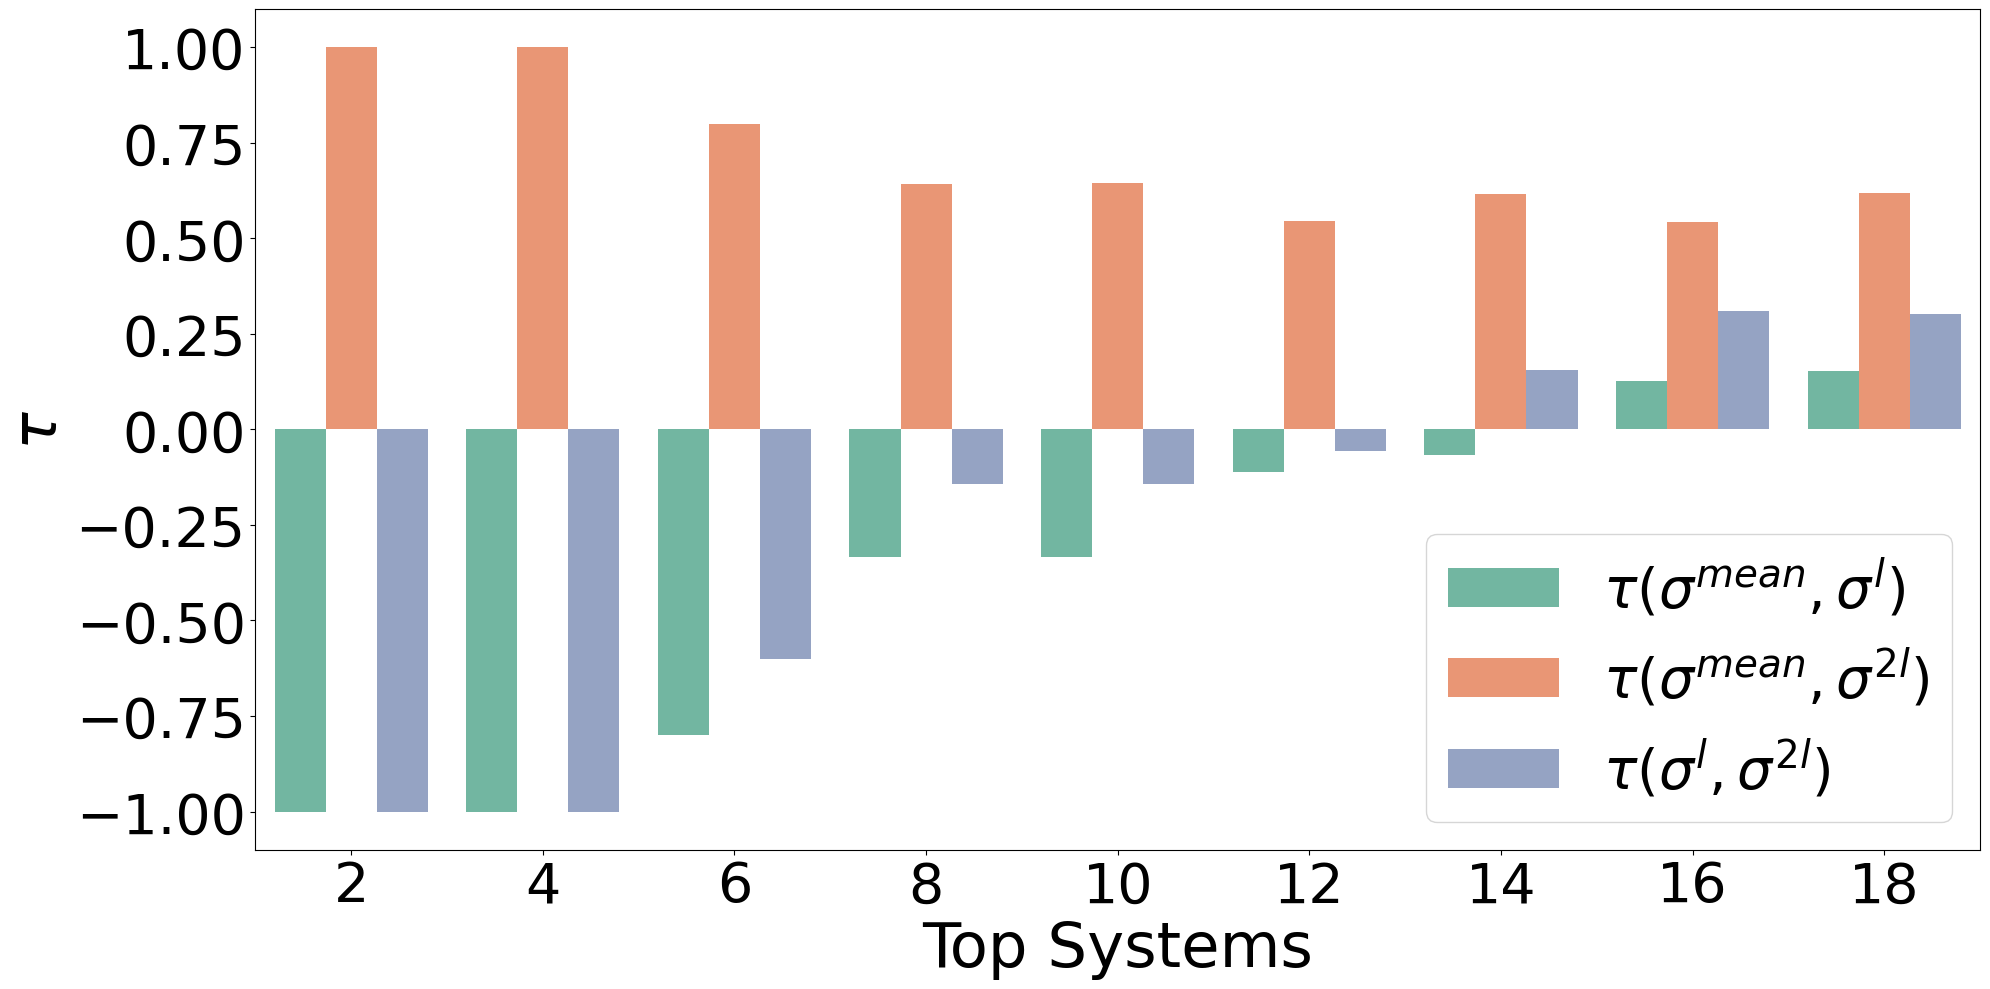

In [28]:
plt.figure(figsize=(20,10))
sns.set_palette("Set2")
data_filter = data_df[data_df.number.isin([int(i) for i in range(0,21,2)])]
data_filter = data_filter[data_filter.ds.isin(['FLICKR.csv'])]
plt.tight_layout()
sns.barplot(data=data_filter, x="number", y="moyen_kendall",hue='method')
plt.ylabel('$\\tau$',size = 45)
leg = plt.legend(fontsize=40)
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('$\\tau(\\sigma^{mean},\\sigma^{l})$')
leg.get_texts()[1].set_text('$\\tau(\\sigma^{mean},\\sigma^{2l})$')
leg.get_texts()[2].set_text('$\\tau(\\sigma^{l},\\sigma^{2l})$')
plt.yticks(fontsize=40) #hue="losses",
plt.xticks(fontsize=40) #hue="losses",
plt.xlabel('Top Systems',size = 45)
plt.tight_layout()
plt.savefig('bar_flick_ranking_analysis.pdf',format='pdf')

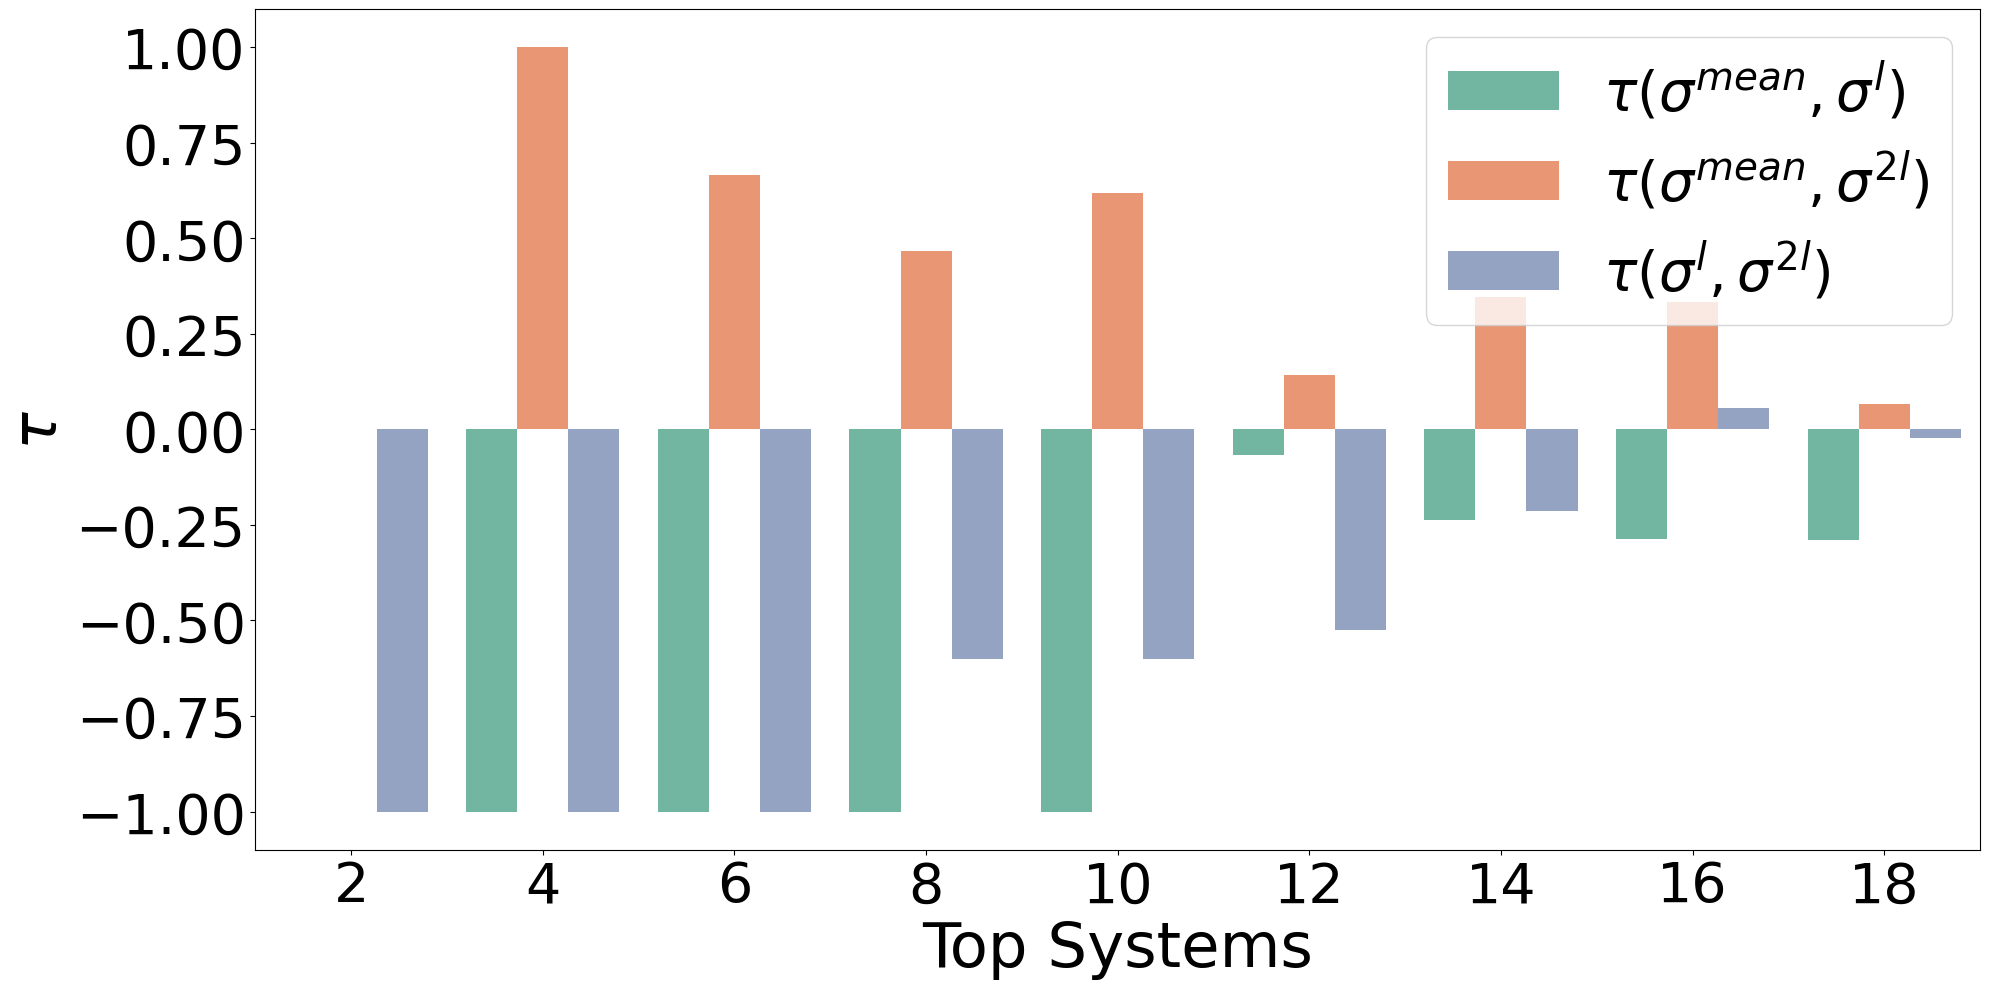

In [29]:
plt.figure(figsize=(20,10))
sns.set_palette("Set2")
data_filter = data_df[data_df.number.isin([int(i) for i in range(0,21,2)])]
data_filter = data_filter[data_filter.ds.isin(['MLQE.csv'])]
sns.barplot(data=data_filter, x="number", y="moyen_kendall",hue='method')
plt.ylabel('$\\tau$',size = 45)
leg = plt.legend(fontsize=40)
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('$\\tau(\\sigma^{mean},\\sigma^{l})$')
leg.get_texts()[1].set_text('$\\tau(\\sigma^{mean},\\sigma^{2l})$')
leg.get_texts()[2].set_text('$\\tau(\\sigma^{l},\\sigma^{2l})$')
plt.yticks(fontsize=40) #hue="losses",
plt.xticks(fontsize=40) #hue="losses",
plt.xlabel('Top Systems',size = 45)
plt.tight_layout()
plt.savefig('bar_mlqe_ranking_analysis.pdf',format='pdf')

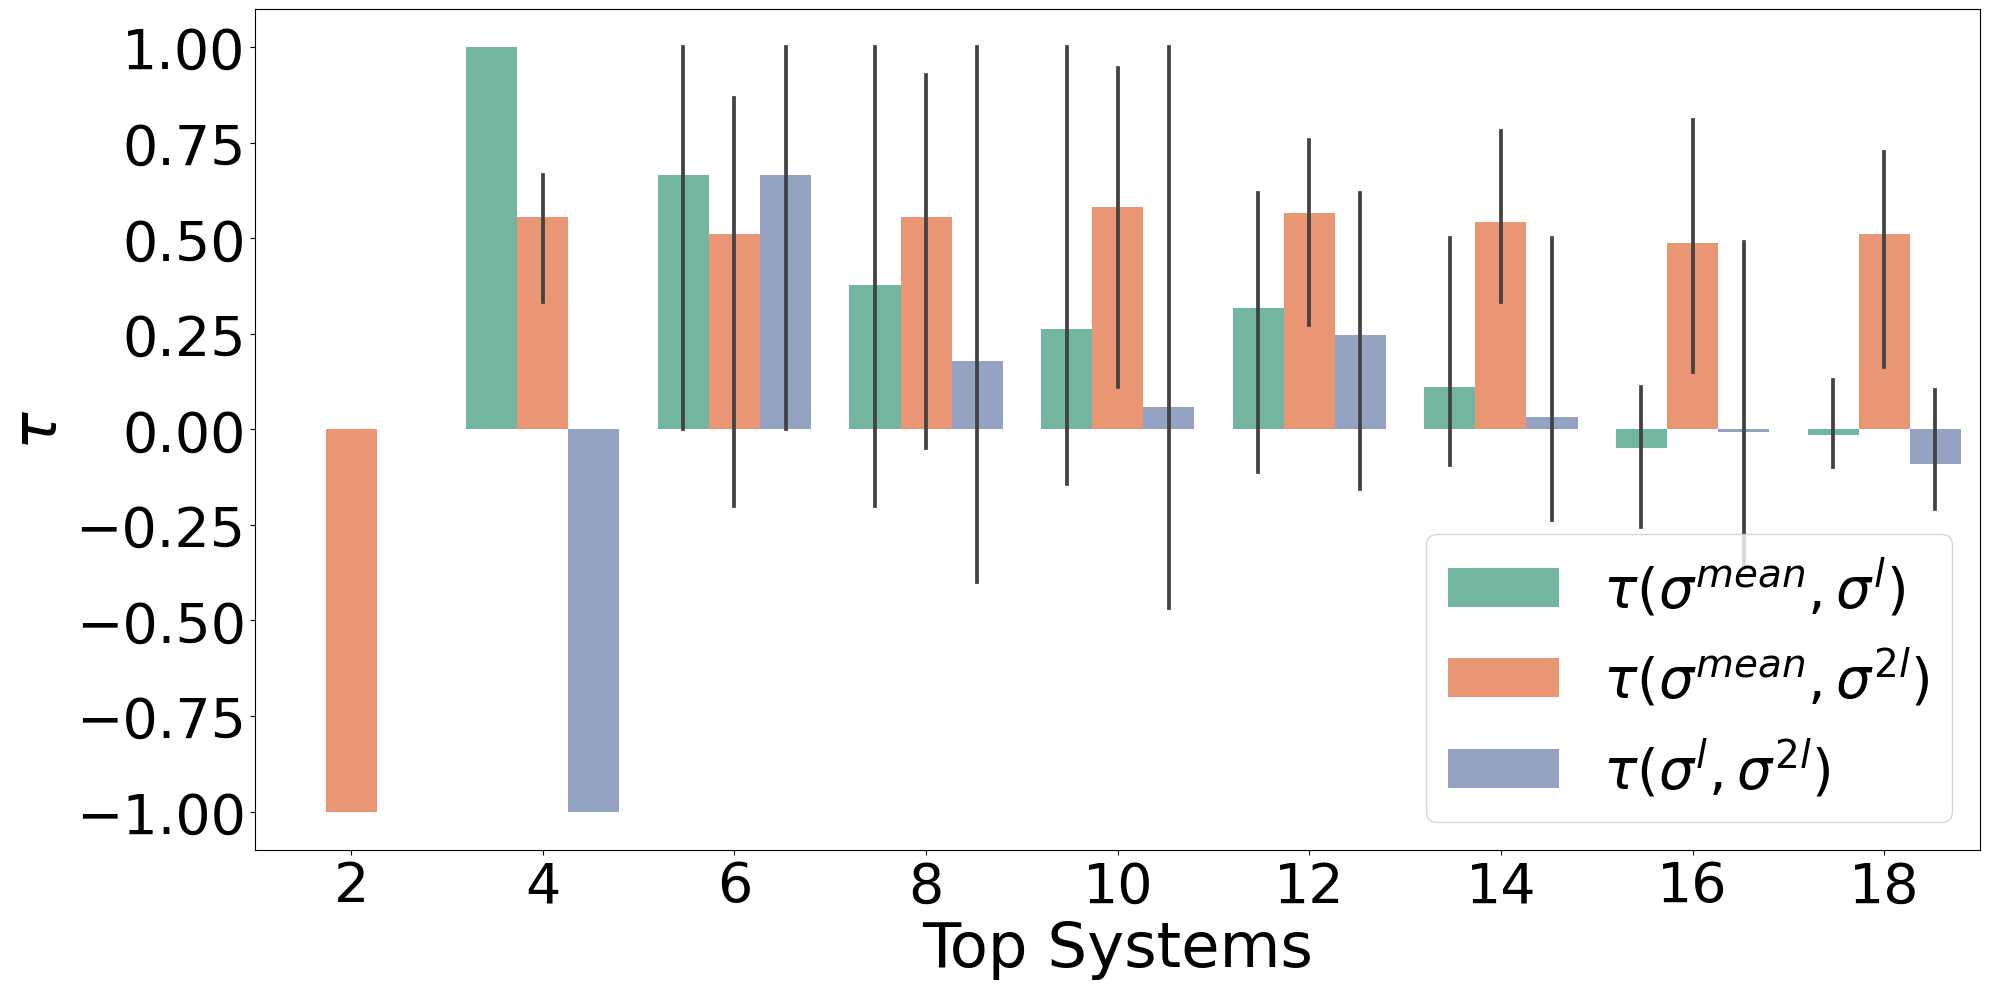

In [30]:
plt.figure(figsize=(20,10))
sns.set_palette("Set2")
data_filter = data_df[data_df.number.isin([int(i) for i in range(0,21,2)])]
data_filter = data_filter[data_filter.ds.isin(['TAC_08.csv','TAC_09.csv','TAC_11.csv'])]
sns.barplot(data=data_filter, x="number", y="moyen_kendall",hue='method')
plt.ylabel('$\\tau$',size = 45)
leg = plt.legend(fontsize=40)
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('$\\tau(\\sigma^{mean},\\sigma^{l})$')
leg.get_texts()[1].set_text('$\\tau(\\sigma^{mean},\\sigma^{2l})$')
leg.get_texts()[2].set_text('$\\tau(\\sigma^{l},\\sigma^{2l})$')
plt.yticks(fontsize=40) #hue="losses",
plt.xticks(fontsize=40) #hue="losses",
plt.xlabel('Top Systems',size = 45)
plt.tight_layout()
plt.savefig('bar_tac_ranking_analysis.pdf',format='pdf')

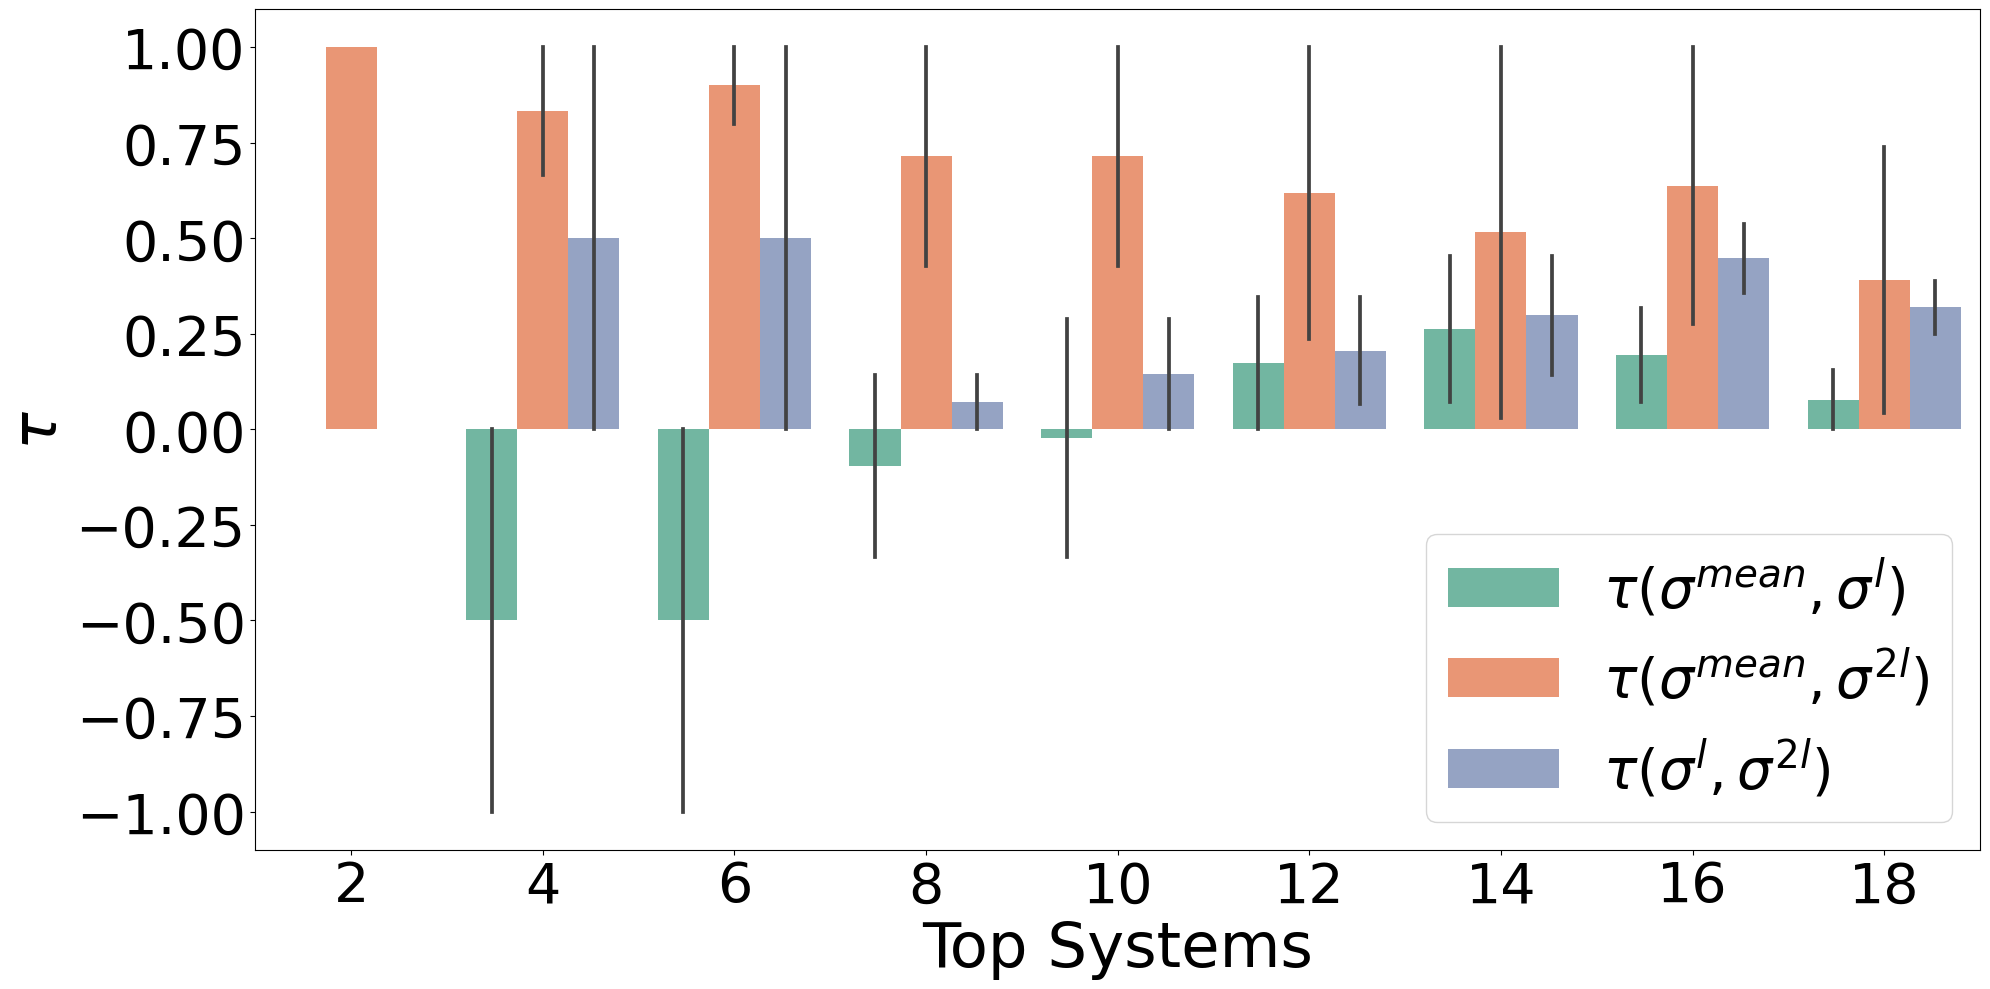

In [31]:
plt.figure(figsize=(20,10))
sns.set_palette("Set2")
data_filter = data_df[data_df.number.isin([int(i) for i in range(0,21,2)])]
data_filter = data_filter[data_filter.ds.isin(['REAL_SUM.csv','SUM_EVAL.csv'])]
sns.barplot(data=data_filter, x="number", y="moyen_kendall",hue='method')
plt.ylabel('$\\tau$',size = 45)
leg = plt.legend(fontsize=40)
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('$\\tau(\\sigma^{mean},\\sigma^{l})$')
leg.get_texts()[1].set_text('$\\tau(\\sigma^{mean},\\sigma^{2l})$')
leg.get_texts()[2].set_text('$\\tau(\\sigma^{l},\\sigma^{2l})$')
plt.yticks(fontsize=40) #hue="losses",
plt.xticks(fontsize=40) #hue="losses",
plt.xlabel('Top Systems',size = 45)
plt.tight_layout()
plt.savefig('bar_sum_ranking_analysis.pdf',format='pdf')

##### Figure 4a)

/tmp/ipykernel_83824/2639192003.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  ax = sns.lineplot(data=data_df, x="number", y="agreement",hue='method',markers=True,ci=50,lw=3.5)


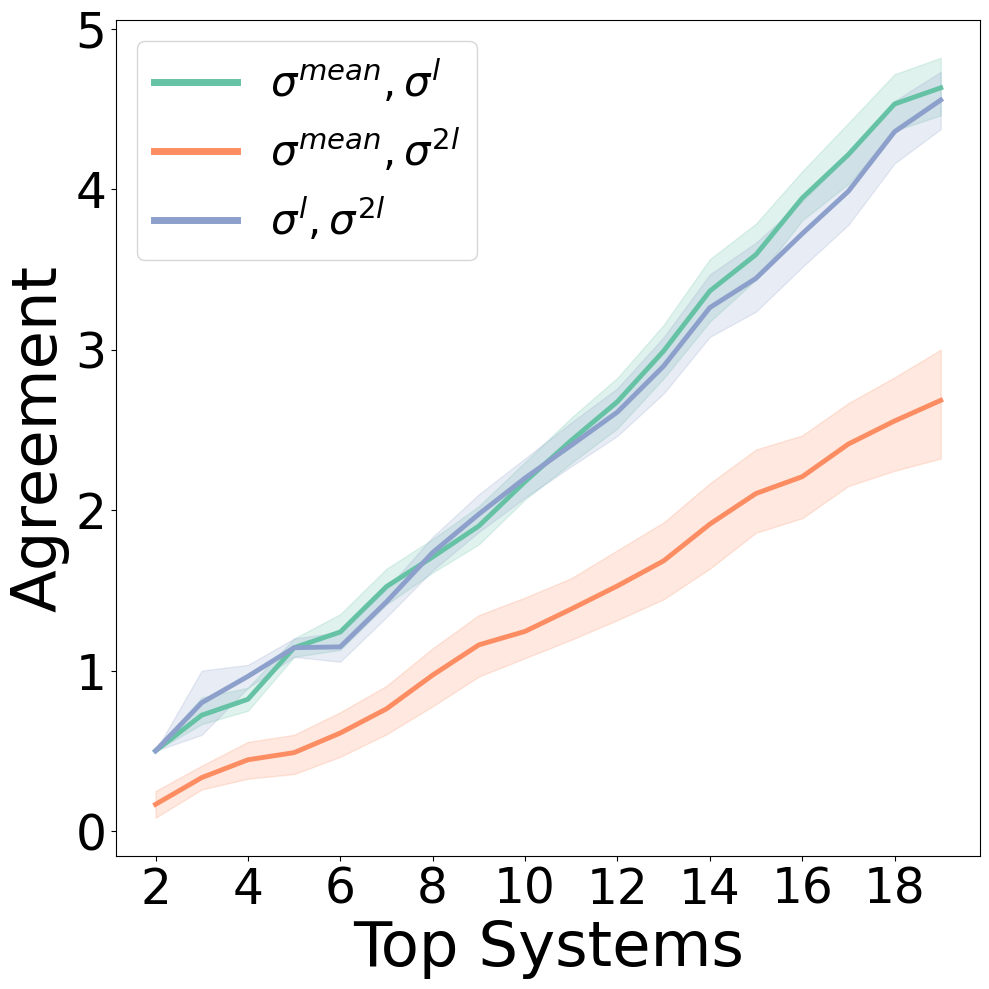

In [33]:
#final_to_plot=  analyse_agreements(data_path = 'final_df', type_of_agreement=1,aggrement = True) 
data_df =pd.DataFrame(final_to_plot)
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(10,10))

ax = sns.lineplot(data=data_df, x="number", y="agreement",hue='method',markers=True,ci=50,lw=3.5)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
leg = plt.legend(fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(5.0)
#leg.get_texts()[0].set_text('Method')
leg.get_texts()[0].set_text('$\\sigma^{mean},\\sigma^{l}$')
leg.get_texts()[1].set_text('$\\sigma^{mean},\\sigma^{2l}$')
leg.get_texts()[2].set_text('$\\sigma^{l},\\sigma^{2l}$')
plt.ylabel('Agreement',size = 45)
plt.xlabel('Top Systems',size = 45)

plt.yticks(fontsize=35) #hue="losses",
plt.xticks(fontsize=35) #hue="losses",

plt.tight_layout()
plt.savefig('all_ranking_analysis_agrement.pdf',format='pdf')

##### Appendix Figures

In [34]:
final_to_plot=  analyse_agreements(data_path = 'final_df', type_of_agreement=1,aggrement = True) 
data_df =pd.DataFrame(final_to_plot)

Datasets:   0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_83824/450897324.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)


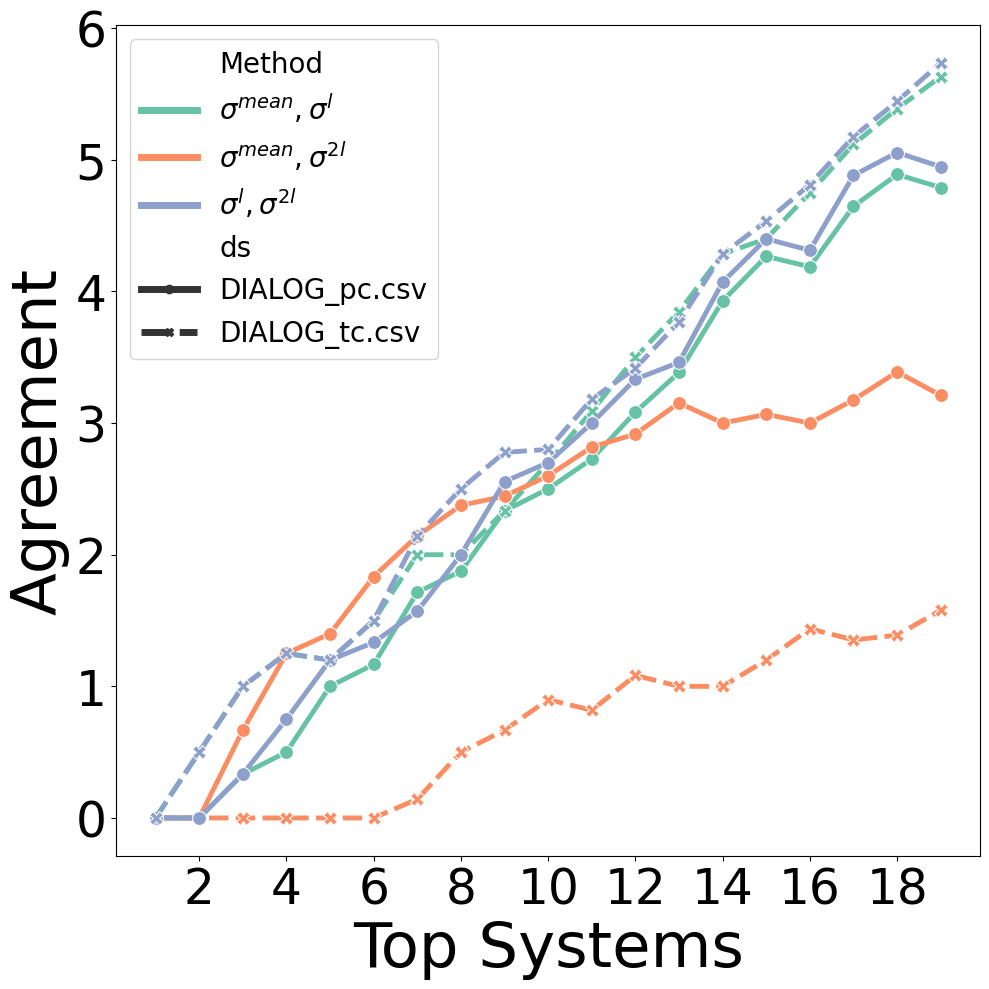

In [35]:
data_df_filtered = data_df[data_df.ds.isin(['DIALOG_pc.csv','DIALOG_tc.csv'])]
plt.figure(figsize=(10,10))
ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
leg = plt.legend(fontsize=20)
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('Method')
leg.get_texts()[1].set_text('$\\sigma^{mean},\\sigma^{l}$')
leg.get_texts()[2].set_text('$\\sigma^{mean},\\sigma^{2l}$')
leg.get_texts()[3].set_text('$\\sigma^{l},\\sigma^{2l}$')
plt.ylabel('Agreement',size = 45)
plt.xlabel('Top Systems',size = 45)

plt.yticks(fontsize=35) #hue="losses",
plt.xticks(fontsize=35) #hue="losses",
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.savefig('dialog_all_ranking_analysis_agrement.pdf',format='pdf')

/tmp/ipykernel_83824/813762154.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)


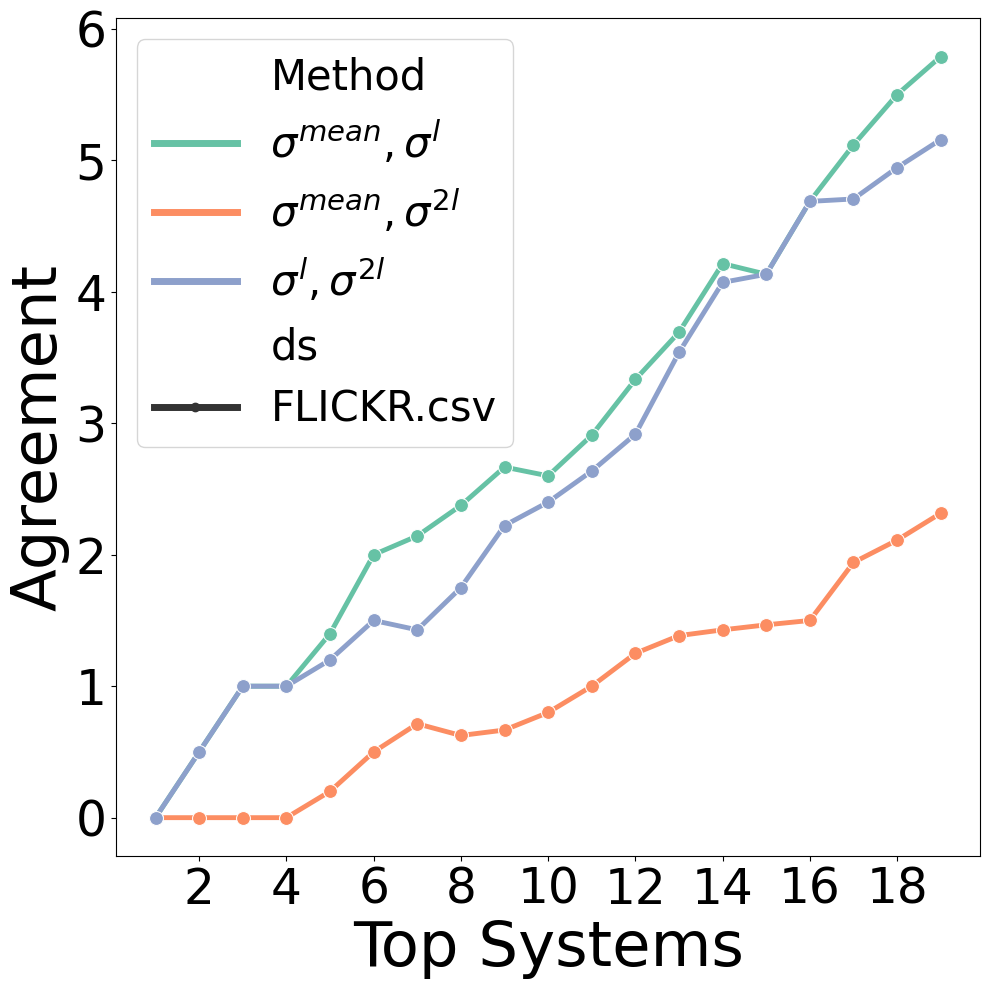

In [36]:
data_df_filtered = data_df[data_df.ds.isin(['FLICKR.csv'])]
plt.figure(figsize=(10,10))
ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)
leg = plt.legend(fontsize=30)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('Method')
leg.get_texts()[1].set_text('$\\sigma^{mean},\\sigma^{l}$')
leg.get_texts()[2].set_text('$\\sigma^{mean},\\sigma^{2l}$')
leg.get_texts()[3].set_text('$\\sigma^{l},\\sigma^{2l}$')
plt.ylabel('Agreement',size = 45)
plt.xlabel('Top Systems',size = 45)

plt.yticks(fontsize=35) #hue="losses",
plt.xticks(fontsize=35) #hue="losses",
plt.tight_layout()
plt.savefig('flickr_all_ranking_analysis_agrement.pdf',format='pdf')

/tmp/ipykernel_83824/888010891.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)


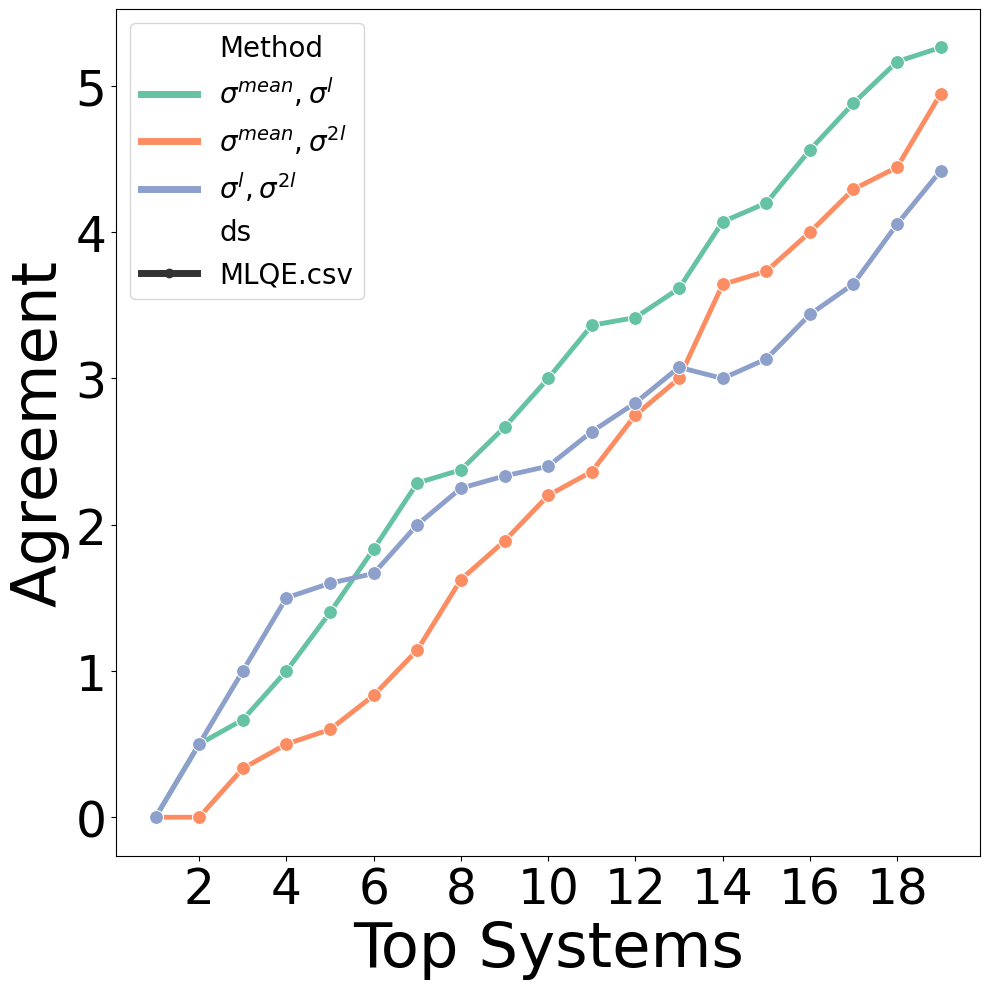

In [37]:
data_df_filtered = data_df[data_df.ds.isin(['MLQE.csv'])]
plt.figure(figsize=(10,10))
ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)
leg = plt.legend(fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('Method')
leg.get_texts()[1].set_text('$\\sigma^{mean},\\sigma^{l}$')
leg.get_texts()[2].set_text('$\\sigma^{mean},\\sigma^{2l}$')
leg.get_texts()[3].set_text('$\\sigma^{l},\\sigma^{2l}$')
plt.ylabel('Agreement',size = 45)
plt.xlabel('Top Systems',size = 45)

plt.yticks(fontsize=35) #hue="losses",
plt.xticks(fontsize=35) #hue="losses",
plt.tight_layout()
plt.savefig('mlqe_all_ranking_analysis_agrement.pdf',format='pdf')

/tmp/ipykernel_83824/192553447.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)


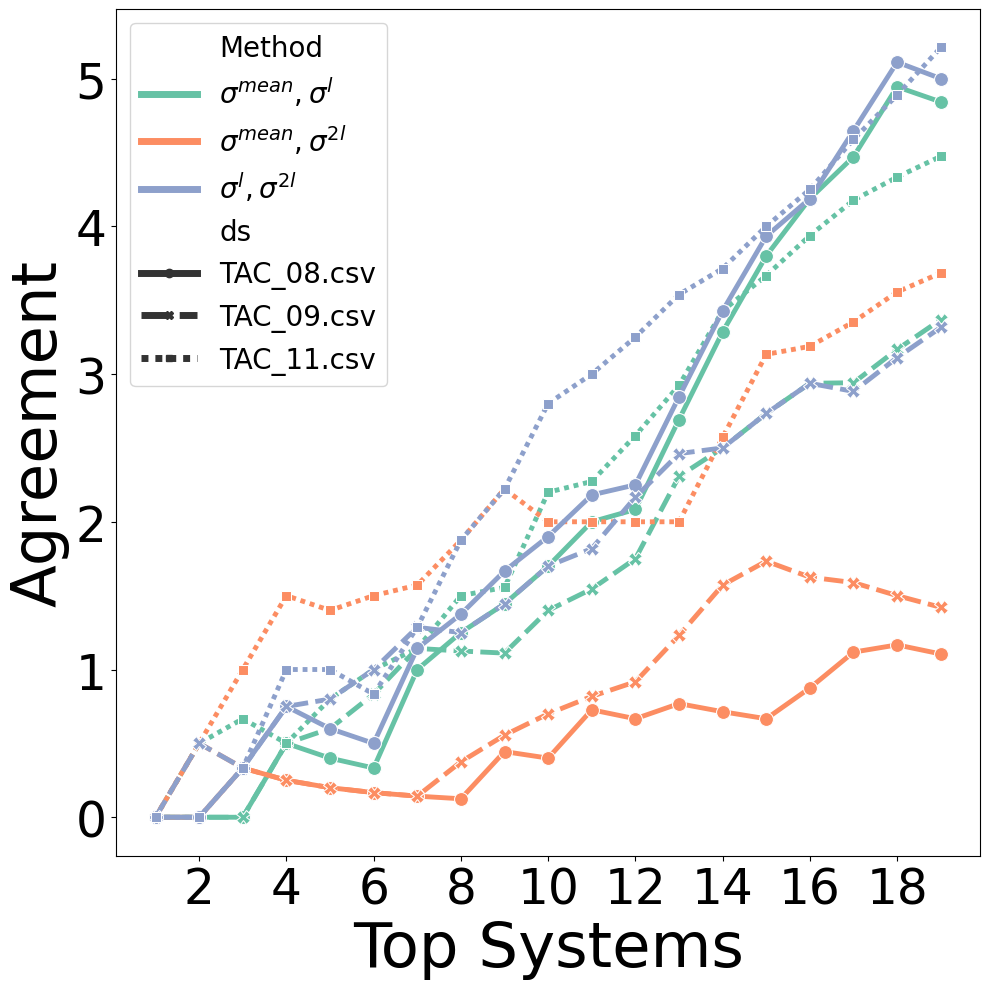

In [38]:
data_df_filtered = data_df[data_df.ds.isin(['TAC_08.csv','TAC_09.csv','TAC_11.csv'])]
plt.figure(figsize=(10,10))
ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)
leg = plt.legend(fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('Method')
leg.get_texts()[1].set_text('$\\sigma^{mean},\\sigma^{l}$')
leg.get_texts()[2].set_text('$\\sigma^{mean},\\sigma^{2l}$')
leg.get_texts()[3].set_text('$\\sigma^{l},\\sigma^{2l}$')
plt.ylabel('Agreement',size = 45)
plt.xlabel('Top Systems',size = 45)

plt.yticks(fontsize=35) #hue="losses",
plt.xticks(fontsize=35) #hue="losses",
plt.tight_layout()
plt.savefig('tac_all_ranking_analysis_agrement.pdf',format='pdf')

/tmp/ipykernel_83824/583845974.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 50)` for the same effect.

  ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)


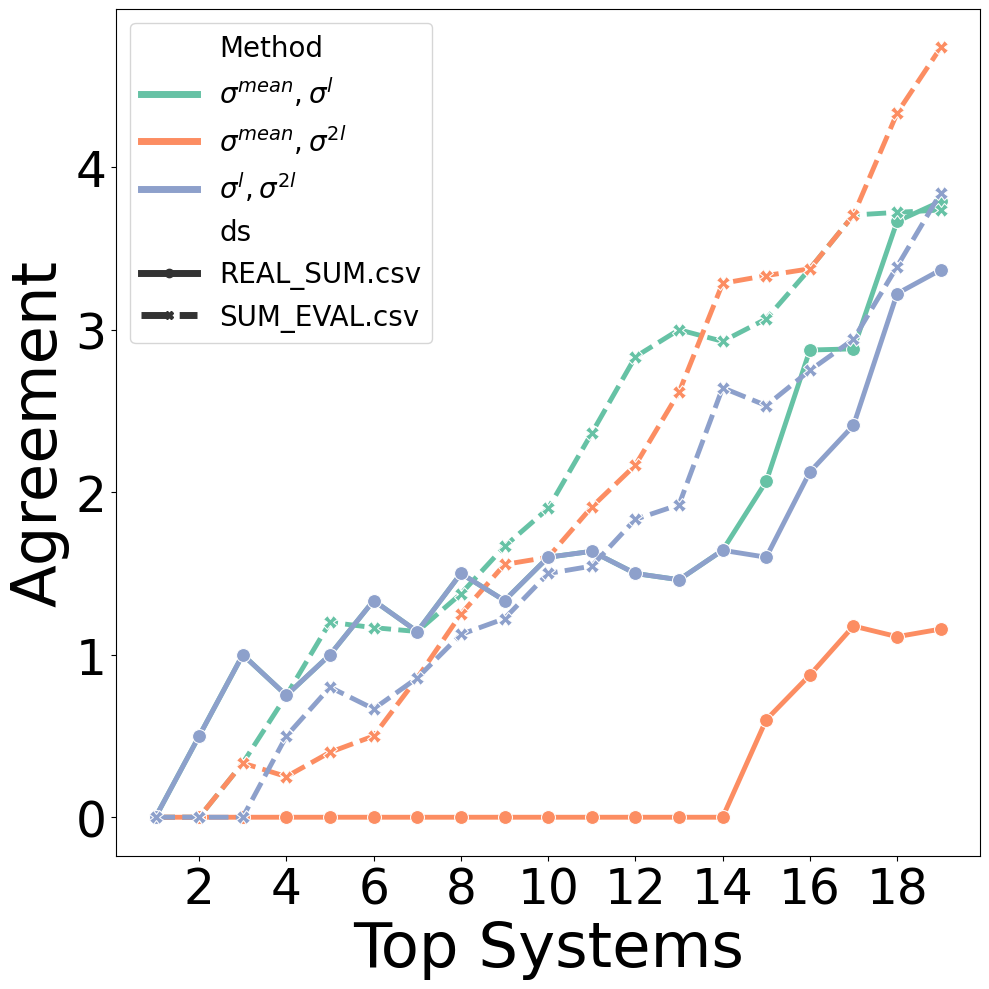

In [39]:
data_df_filtered = data_df[data_df.ds.isin(['REAL_SUM.csv','SUM_EVAL.csv'])]
plt.figure(figsize=(10,10))
ax = sns.lineplot(data=data_df_filtered, x="number", y="agreement",hue='method',style='ds', markers=True,ci=50,lw=3.5,markersize=10)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
leg = plt.legend(fontsize=20)
for line in leg.get_lines():
    line.set_linewidth(5.0)
leg.get_texts()[0].set_text('Method')
leg.get_texts()[1].set_text('$\\sigma^{mean},\\sigma^{l}$')
leg.get_texts()[2].set_text('$\\sigma^{mean},\\sigma^{2l}$')
leg.get_texts()[3].set_text('$\\sigma^{l},\\sigma^{2l}$')
plt.ylabel('Agreement',size = 45)
plt.xlabel('Top Systems',size = 45)

plt.yticks(fontsize=35) #hue="losses",
plt.xticks(fontsize=35) #hue="losses",
plt.tight_layout()
plt.savefig('sum_all_ranking_analysis_agrement.pdf',format='pdf')